In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import yfinance as yf
import seaborn as sns
import math

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, Bidirectional, TimeDistributed, Flatten, Activation, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint

from tqdm.notebook import tqdm
from statistics import mean
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

# Load & Prepare Data

In [3]:
# Load Data
df = yf.download(tickers='RCDO.L', start='2012-01-01', end='2023-01-01')
df = df[['Close']]
df

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2012-01-03,381.5
2012-01-04,384.0
2012-01-05,383.5
2012-01-06,383.5
2012-01-09,380.0
...,...
2022-12-22,475.0
2022-12-23,475.0
2022-12-28,477.5


In [4]:
# training between 2012 and 2022
train_data_df = df[df.index < '2022-01-01'].copy()

# validation on 2022
val_data_df = df[df.index >= '2022-01-01'].copy()

display(train_data_df, val_data_df)

,Close
Date,
2012-01-03,381.5
2012-01-04,384.0
2012-01-05,383.5
2012-01-06,383.5
2012-01-09,380.0
...,...
2021-12-23,465.0
2021-12-24,464.0
2021-12-29,462.0


,Close
Date,
2022-01-04,457.0
2022-01-05,463.0
2022-01-06,466.0
2022-01-07,467.0
2022-01-10,463.0
...,...
2022-12-22,475.0
2022-12-23,475.0
2022-12-28,477.5


# Models

In [5]:
def plot_loss(history):
    plt.plot(history.history['loss'], label = 'Training Loss')
    plt.plot(history.history['val_loss'], label = 'Validation Loss')
    plt.yticks([i/1000 for i in range(0, 25, 5)])
    plt.legend()
    plt.show()

In [12]:
def visualise_predicitons(test_data_df, pred):
    """Plot predictions against actual test data"""
    
    sns.set(style="darkgrid")
    pred_ = pd.DataFrame(test_data_df['Close'])
    pred_['predicted close'] = pred
    
    plt.figure(figsize=(28,12))
    sns.lineplot(test_data_df['Close'])
    sns.lineplot(pred_['predicted close'])
    plt.title("RCDO Stock Price Prediction")
    plt.xlabel("Date")
    plt.ylabel("Close Price (GBp)")
    plt.legend(['Actual Values', 'Predicted Values', 'Validation'])
    plt.show()

In [7]:
def run_model(train_data_df, val_data_df, chosen_model):

    #### Prepare Train Data ####
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_train_data = scaler.fit_transform(train_data_df)

    prediction_days = 7

    x_train = []
    y_train = []

    for i in range(prediction_days, len(scaled_train_data)):
        x_train.append(scaled_train_data[i-prediction_days:i])
        y_train.append(scaled_train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)

    # https://towardsdatascience.com/forecasting-with-technical-indicators-and-gru-lstm-rnn-multivariate-time-series-a3244dcbc38b
    #### Prepare Val Data ####
    look_back = train_data_df.tail(prediction_days)
    val_data = look_back.append(val_data_df)

    scaled_val_data = scaler.transform(val_data)

    x_val = []
    y_val = []
    
    for i in range(prediction_days, len(scaled_val_data)):
        x_val.append(scaled_val_data[i-prediction_days:i])
        y_val.append(scaled_val_data[i, 0])

    x_val, y_val = np.array(x_val), np.array(y_val)
    
    ##### Run model #####
    model = chosen_model
    model.summary()
    model.compile(optimizer='adam', 
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    
    history = model.fit(x_train, y_train, validation_split=0.1, epochs=100)
    
    ##### Plot loss #####
    plot_loss(history)

    ##### Generate predictions (probabilities - the output of the last layer) on new data using `predict` #####
    print("Generate predictions for 7 samples")
    predictions = model.predict(x_val[:7])
    print("predictions shape:", predictions.shape)
    print(predictions)
    
    ##### Metrics #####
    pred = model.predict(x_val)
    print(pred.shape)

    # Inverse MinMax Transformation
    # Requires same amount of fields
    # https://stackoverflow.com/questions/42997228/lstm-keras-error-valueerror-non-broadcastable-output-operand-with-shape-67704
    # create empty table with 12 fields
    pred_like = np.zeros(shape=(len(pred), 1) )
    # put the predicted values in the right field
    pred_like[:,0] = pred[:,0]
    # inverse transform and then select the right field
    pred = scaler.inverse_transform(pred_like)[:,0]

    print('mae:', mean_absolute_error(val_data_df['Close'], pred))
    print('mape:', mean_absolute_percentage_error(val_data_df['Close'], pred))
    print('mse:', mean_squared_error(val_data_df['Close'], pred))
    print('rmse:', math.sqrt(mean_squared_error(val_data_df['Close'], pred)))

    ##### Visualise #####
    print(y_val.shape, pred.shape)
    visualise_predicitons(val_data_df, pred)

    display(pd.DataFrame(data={'Train Predictions':pred.flatten(), 'Actuals':val_data_df['Close']}))

In [8]:
def run_model_average(train_data_df, val_data_df, chosen_model):

    #### Prepare Train Data ####
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_train_data = scaler.fit_transform(train_data_df)

    prediction_days = 7

    x_train = []
    y_train = []

    for i in range(prediction_days, len(scaled_train_data)):
        x_train.append(scaled_train_data[i-prediction_days:i])
        y_train.append(scaled_train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)

    # https://towardsdatascience.com/forecasting-with-technical-indicators-and-gru-lstm-rnn-multivariate-time-series-a3244dcbc38b
    #### Prepare Val Data ####
    look_back = train_data_df.tail(prediction_days)
    val_data = look_back.append(val_data_df)

    scaled_val_data = scaler.transform(val_data)

    x_val = []
    y_val = []
    
    for i in range(prediction_days, len(scaled_val_data)):
        x_val.append(scaled_val_data[i-prediction_days:i])
        y_val.append(scaled_val_data[i, 0])

    x_val, y_val = np.array(x_val), np.array(y_val)
    
    mape_values = []
    mae_values = []
    mse_values = []
    rmse_values = []
    
    for i in (range(35)):
        
        ##### Run model #####
        model = chosen_model
        model.summary()
        model.compile(optimizer='adam', 
                      loss='mean_squared_error',
                      metrics=['mean_absolute_error'])

        history = model.fit(x_train, y_train, validation_split=0.1, epochs=100)

        ##### Generate predictions (probabilities - the output of the last layer) on new data using `predict` #####
        print("Generate predictions for 7 samples")
        predictions = model.predict(x_val[:7])
        print("predictions shape:", predictions.shape)
        print(predictions)

        ##### Metrics #####
        pred = model.predict(x_val)
        print(pred.shape)

        # Inverse MinMax Transformation
        # Requires same amount of fields
        # https://stackoverflow.com/questions/42997228/lstm-keras-error-valueerror-non-broadcastable-output-operand-with-shape-67704
        # create empty table with 12 fields
        pred_like = np.zeros(shape=(len(pred), 1) )
        # put the predicted values in the right field
        pred_like[:,0] = pred[:,0]
        # inverse transform and then select the right field
        pred = scaler.inverse_transform(pred_like)[:,0]
    
        mae_values.append(mean_absolute_error(val_data_df['Close'], pred))
        mape_values.append(mean_absolute_percentage_error(val_data_df['Close'], pred))
        mse_values.append(mean_squared_error(val_data_df['Close'], pred))
        rmse_values.append(math.sqrt(mean_squared_error(val_data_df['Close'], pred)))
        
        print(mean(mae_values), mean(mape_values), mean(mse_values), mean(rmse_values))
        
    return mae_values, mape_values, mse_values, rmse_values

In [9]:
compare_df = pd.DataFrame(columns=['Name', 'MAE', 'MAPE', 'MSE', 'RMSE'])

## Stacked LSTM

In [15]:
def stacked_lstm():
    model = Sequential()
    model.add(Input((7, 1)))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(1, activation='tanh'))
    return model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 7, 64)             16896     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
71/71 [==============================] - 4s 13ms/step - loss: 0.0359 - mean_absolute_error: 0.1230 - val_loss: 9.2831e-04 - val_mean_absolute_error: 0.0253
Epoch 2/100
71

71/71 [==============================] - 0s 5ms/step - loss: 4.9877e-04 - mean_absolute_error: 0.0152 - val_loss: 1.9917e-04 - val_mean_absolute_error: 0.0102
Epoch 44/100
71/71 [==============================] - 0s 5ms/step - loss: 4.9465e-04 - mean_absolute_error: 0.0153 - val_loss: 1.8684e-04 - val_mean_absolute_error: 0.0099
Epoch 45/100
71/71 [==============================] - 0s 5ms/step - loss: 4.8783e-04 - mean_absolute_error: 0.0150 - val_loss: 1.8414e-04 - val_mean_absolute_error: 0.0097
Epoch 46/100
71/71 [==============================] - 0s 5ms/step - loss: 4.7989e-04 - mean_absolute_error: 0.0149 - val_loss: 2.1230e-04 - val_mean_absolute_error: 0.0107
Epoch 47/100
71/71 [==============================] - 0s 5ms/step - loss: 4.7576e-04 - mean_absolute_error: 0.0148 - val_loss: 1.6821e-04 - val_mean_absolute_error: 0.0094
Epoch 48/100
71/71 [==============================] - 0s 5ms/step - loss: 4.6487e-04 - mean_absolute_error: 0.0147 - val_loss: 1.7488e-04 - val_mean_abso

Epoch 91/100
71/71 [==============================] - 0s 5ms/step - loss: 4.1346e-04 - mean_absolute_error: 0.0142 - val_loss: 1.3003e-04 - val_mean_absolute_error: 0.0081
Epoch 92/100
71/71 [==============================] - 0s 5ms/step - loss: 3.9891e-04 - mean_absolute_error: 0.0140 - val_loss: 1.5501e-04 - val_mean_absolute_error: 0.0088
Epoch 93/100
71/71 [==============================] - 0s 5ms/step - loss: 4.1192e-04 - mean_absolute_error: 0.0144 - val_loss: 1.9039e-04 - val_mean_absolute_error: 0.0108
Epoch 94/100
71/71 [==============================] - 0s 5ms/step - loss: 3.8713e-04 - mean_absolute_error: 0.0137 - val_loss: 2.1813e-04 - val_mean_absolute_error: 0.0116
Epoch 95/100
71/71 [==============================] - 0s 5ms/step - loss: 4.5737e-04 - mean_absolute_error: 0.0154 - val_loss: 1.7412e-04 - val_mean_absolute_error: 0.0097
Epoch 96/100
71/71 [==============================] - 0s 5ms/step - loss: 3.7868e-04 - mean_absolute_error: 0.0135 - val_loss: 1.3315e-04 - 

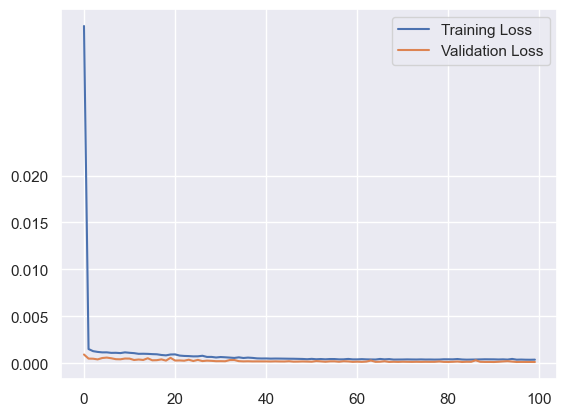

Generate predictions for 7 samples
1/1 [==============================] - 1s 581ms/step
predictions shape: (7, 1)
[[0.1884797 ]
 [0.19613512]
 [0.20472258]
 [0.20959046]
 [0.21116197]
 [0.20668192]
 [0.20233971]]
8/8 [==============================] - 0s 2ms/step
(250, 1)
mae: 5.818197881773115
mape: 0.013943901243163371
mse: 63.200659331158946
rmse: 7.949884233821203
(250,) (250,)


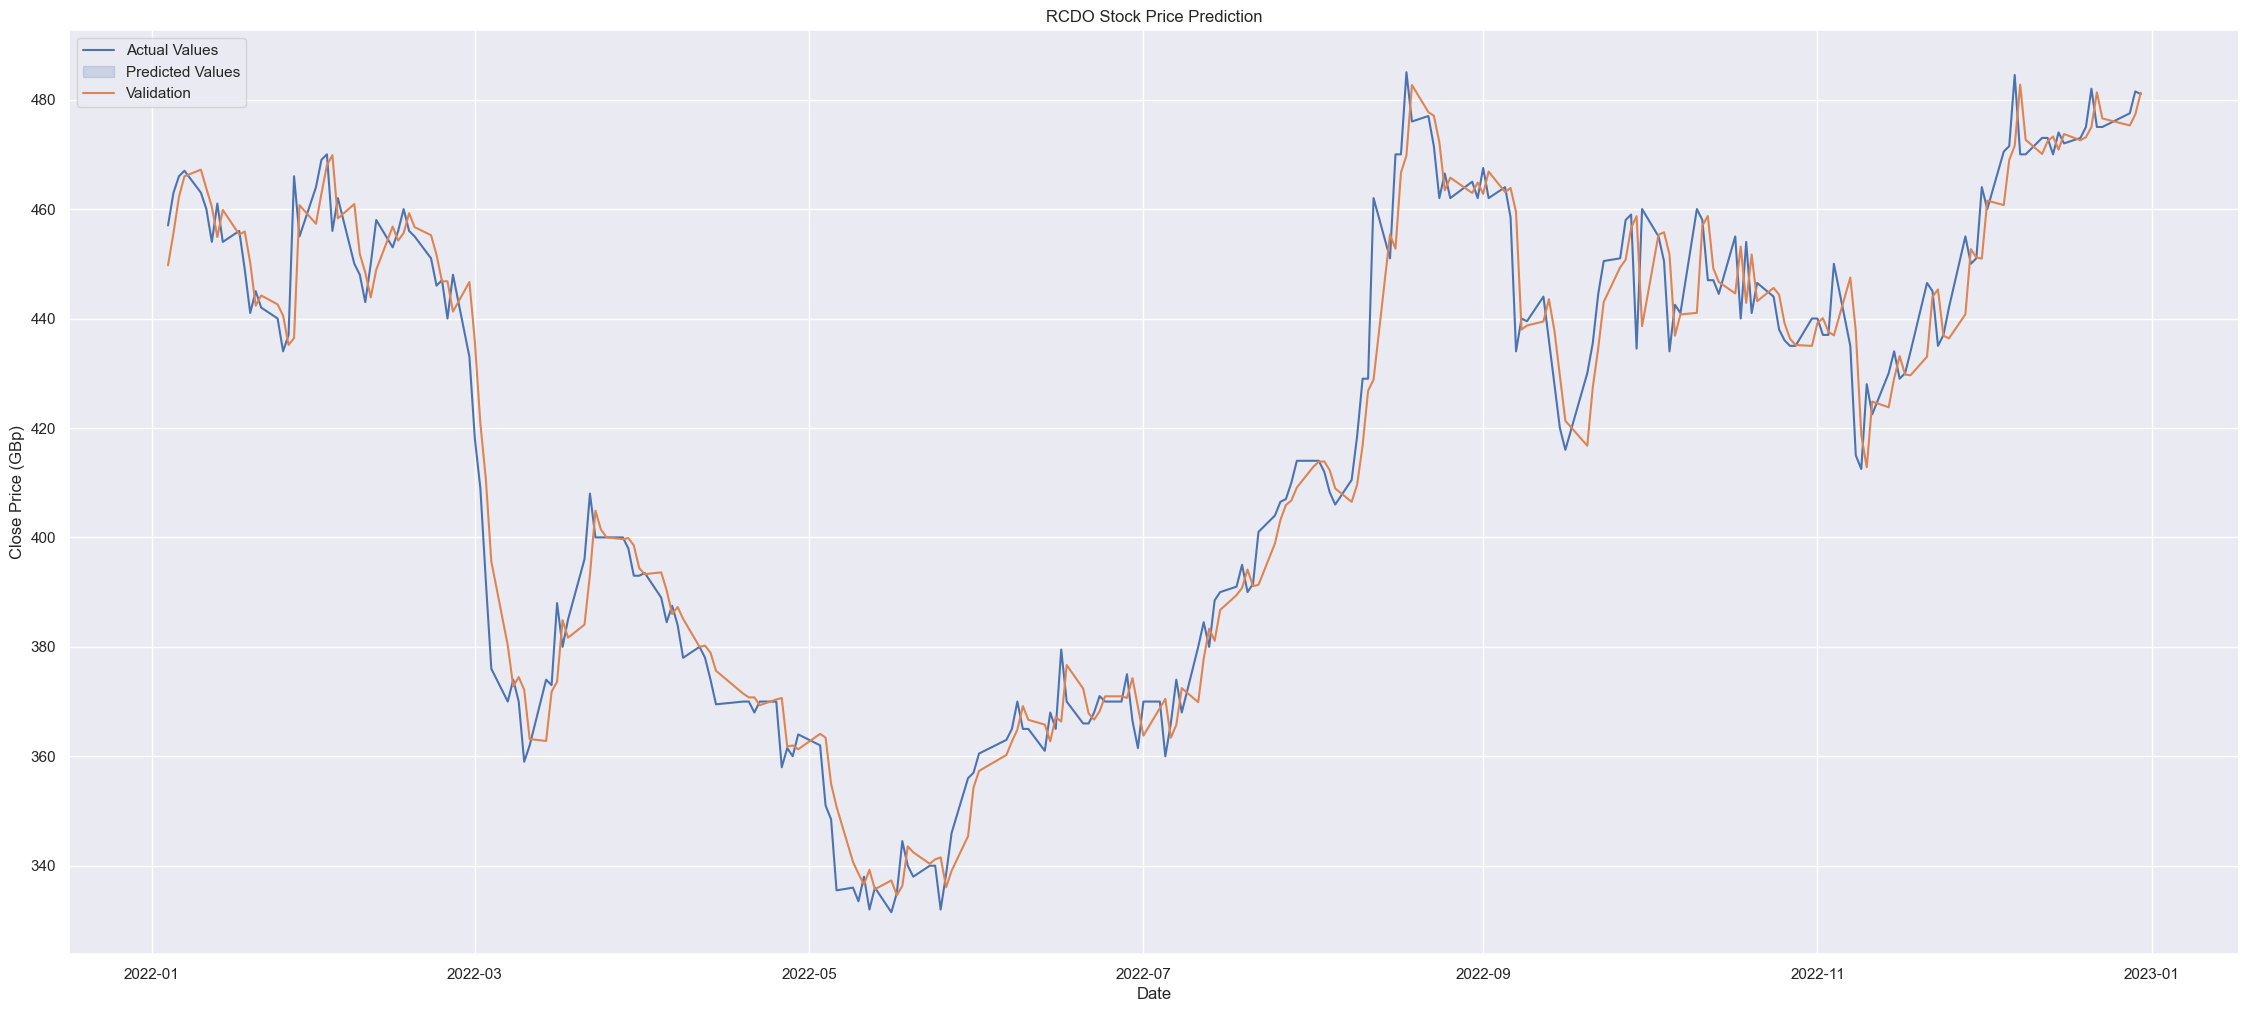

,Train Predictions,Actuals
Date,,
2022-01-04,449.723614,457.0
2022-01-05,455.622109,463.0
2022-01-06,462.238750,466.0
2022-01-07,465.989453,467.0
2022-01-10,467.200299,463.0
...,...,...
2022-12-22,481.319482,475.0
2022-12-23,476.555861,475.0
2022-12-28,475.277723,477.5


In [14]:
run_model(train_data_df, val_data_df, chosen_model = stacked_lstm())

In [11]:
mae_values_2, mape_values_2, mse_values_2, rmse_values_2 = run_model_average(train_data_df, val_data_df, chosen_model = stacked_lstm())
 
model_dict = {
'Name':'LSTM 2',
'MAE': round(mean(mae_values_2), 4),
"MAPE": round(mean(mape_values_2), 4),
"MSE": round(mean(mse_values_2), 4),
"RMSE": round(mean(rmse_values_2), 4)
}

compare_df = compare_df.append(model_dict, ignore_index=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 7, 64)             16896     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
71/71 [==============================] - 4s 14ms/step - loss: 0.0323 - mean_absolute_error: 0.1155 - val_loss: 9.7346e-04 - val_mean_absolute_error: 0.0261
Epoch 2/100
71

Epoch 91/100
71/71 [==============================] - 0s 6ms/step - loss: 3.8525e-04 - mean_absolute_error: 0.0136 - val_loss: 1.6984e-04 - val_mean_absolute_error: 0.0096
Epoch 92/100
71/71 [==============================] - 0s 6ms/step - loss: 4.2894e-04 - mean_absolute_error: 0.0147 - val_loss: 1.4076e-04 - val_mean_absolute_error: 0.0082
Epoch 93/100
71/71 [==============================] - 0s 6ms/step - loss: 3.9694e-04 - mean_absolute_error: 0.0139 - val_loss: 1.2798e-04 - val_mean_absolute_error: 0.0080
Epoch 94/100
71/71 [==============================] - 0s 6ms/step - loss: 3.9126e-04 - mean_absolute_error: 0.0138 - val_loss: 1.2909e-04 - val_mean_absolute_error: 0.0079
Epoch 95/100
71/71 [==============================] - 0s 6ms/step - loss: 3.7920e-04 - mean_absolute_error: 0.0134 - val_loss: 1.4016e-04 - val_mean_absolute_error: 0.0084
Epoch 96/100
71/71 [==============================] - 0s 6ms/step - loss: 3.8383e-04 - mean_absolute_error: 0.0137 - val_loss: 1.8409e-04 - 

Epoch 79/100
71/71 [==============================] - 0s 5ms/step - loss: 3.9218e-04 - mean_absolute_error: 0.0137 - val_loss: 1.4516e-04 - val_mean_absolute_error: 0.0089
Epoch 80/100
71/71 [==============================] - 0s 5ms/step - loss: 3.7149e-04 - mean_absolute_error: 0.0134 - val_loss: 1.3057e-04 - val_mean_absolute_error: 0.0080
Epoch 81/100
71/71 [==============================] - 0s 6ms/step - loss: 3.7159e-04 - mean_absolute_error: 0.0134 - val_loss: 1.7312e-04 - val_mean_absolute_error: 0.0101
Epoch 82/100
71/71 [==============================] - 0s 5ms/step - loss: 3.8883e-04 - mean_absolute_error: 0.0140 - val_loss: 1.6844e-04 - val_mean_absolute_error: 0.0095
Epoch 83/100
71/71 [==============================] - 0s 5ms/step - loss: 3.7719e-04 - mean_absolute_error: 0.0134 - val_loss: 1.3234e-04 - val_mean_absolute_error: 0.0080
Epoch 84/100
71/71 [==============================] - 0s 5ms/step - loss: 3.6620e-04 - mean_absolute_error: 0.0131 - val_loss: 1.6659e-04 - 

Epoch 67/100
71/71 [==============================] - 0s 6ms/step - loss: 3.5972e-04 - mean_absolute_error: 0.0131 - val_loss: 1.2789e-04 - val_mean_absolute_error: 0.0080
Epoch 68/100
71/71 [==============================] - 0s 6ms/step - loss: 3.5210e-04 - mean_absolute_error: 0.0128 - val_loss: 1.6648e-04 - val_mean_absolute_error: 0.0095
Epoch 69/100
71/71 [==============================] - 0s 6ms/step - loss: 3.5261e-04 - mean_absolute_error: 0.0129 - val_loss: 1.3569e-04 - val_mean_absolute_error: 0.0084
Epoch 70/100
71/71 [==============================] - 0s 6ms/step - loss: 3.8266e-04 - mean_absolute_error: 0.0136 - val_loss: 1.4513e-04 - val_mean_absolute_error: 0.0086
Epoch 71/100
71/71 [==============================] - 0s 6ms/step - loss: 3.6272e-04 - mean_absolute_error: 0.0130 - val_loss: 1.6591e-04 - val_mean_absolute_error: 0.0095
Epoch 72/100
71/71 [==============================] - 0s 6ms/step - loss: 3.6094e-04 - mean_absolute_error: 0.0131 - val_loss: 1.2804e-04 - 

Epoch 55/100
71/71 [==============================] - 0s 5ms/step - loss: 3.8252e-04 - mean_absolute_error: 0.0136 - val_loss: 1.3639e-04 - val_mean_absolute_error: 0.0082
Epoch 56/100
71/71 [==============================] - 0s 5ms/step - loss: 3.5128e-04 - mean_absolute_error: 0.0128 - val_loss: 2.8282e-04 - val_mean_absolute_error: 0.0139
Epoch 57/100
71/71 [==============================] - 0s 5ms/step - loss: 3.6290e-04 - mean_absolute_error: 0.0131 - val_loss: 1.6364e-04 - val_mean_absolute_error: 0.0094
Epoch 58/100
71/71 [==============================] - 0s 5ms/step - loss: 3.6087e-04 - mean_absolute_error: 0.0130 - val_loss: 1.5700e-04 - val_mean_absolute_error: 0.0091
Epoch 59/100
71/71 [==============================] - 0s 6ms/step - loss: 3.7322e-04 - mean_absolute_error: 0.0135 - val_loss: 1.5671e-04 - val_mean_absolute_error: 0.0090
Epoch 60/100
71/71 [==============================] - 0s 6ms/step - loss: 3.6083e-04 - mean_absolute_error: 0.0130 - val_loss: 1.3144e-04 - 

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 7, 64)             16896     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
71/71 [==============================] - 4s 14ms/step - loss: 3.7437e-04 - mean_absolute_error: 0.0136 - val_loss: 1.3645e-04 - val_mean_absolute_error: 0.0083
Epoch 2/100
71/71 [=============

Epoch 91/100
71/71 [==============================] - 0s 5ms/step - loss: 3.4777e-04 - mean_absolute_error: 0.0130 - val_loss: 2.1360e-04 - val_mean_absolute_error: 0.0113
Epoch 92/100
71/71 [==============================] - 0s 5ms/step - loss: 3.5349e-04 - mean_absolute_error: 0.0130 - val_loss: 1.9846e-04 - val_mean_absolute_error: 0.0107
Epoch 93/100
71/71 [==============================] - 0s 5ms/step - loss: 3.6469e-04 - mean_absolute_error: 0.0134 - val_loss: 1.3479e-04 - val_mean_absolute_error: 0.0084
Epoch 94/100
71/71 [==============================] - 0s 5ms/step - loss: 3.5320e-04 - mean_absolute_error: 0.0131 - val_loss: 1.3419e-04 - val_mean_absolute_error: 0.0081
Epoch 95/100
71/71 [==============================] - 0s 5ms/step - loss: 3.5797e-04 - mean_absolute_error: 0.0132 - val_loss: 1.3069e-04 - val_mean_absolute_error: 0.0080
Epoch 96/100
71/71 [==============================] - 0s 5ms/step - loss: 3.5430e-04 - mean_absolute_error: 0.0132 - val_loss: 1.3119e-04 - 

Epoch 79/100
71/71 [==============================] - 0s 6ms/step - loss: 3.5050e-04 - mean_absolute_error: 0.0134 - val_loss: 1.3188e-04 - val_mean_absolute_error: 0.0081
Epoch 80/100
71/71 [==============================] - 0s 6ms/step - loss: 3.3225e-04 - mean_absolute_error: 0.0127 - val_loss: 1.3068e-04 - val_mean_absolute_error: 0.0080
Epoch 81/100
71/71 [==============================] - 0s 5ms/step - loss: 3.3112e-04 - mean_absolute_error: 0.0126 - val_loss: 1.3494e-04 - val_mean_absolute_error: 0.0082
Epoch 82/100
71/71 [==============================] - 0s 5ms/step - loss: 3.3442e-04 - mean_absolute_error: 0.0127 - val_loss: 1.5138e-04 - val_mean_absolute_error: 0.0092
Epoch 83/100
71/71 [==============================] - 0s 5ms/step - loss: 3.4258e-04 - mean_absolute_error: 0.0130 - val_loss: 1.3610e-04 - val_mean_absolute_error: 0.0084
Epoch 84/100
71/71 [==============================] - 0s 5ms/step - loss: 3.3831e-04 - mean_absolute_error: 0.0128 - val_loss: 1.5517e-04 - 

Epoch 67/100
71/71 [==============================] - 0s 5ms/step - loss: 3.2910e-04 - mean_absolute_error: 0.0127 - val_loss: 1.5113e-04 - val_mean_absolute_error: 0.0087
Epoch 68/100
71/71 [==============================] - 0s 6ms/step - loss: 3.3260e-04 - mean_absolute_error: 0.0127 - val_loss: 1.2853e-04 - val_mean_absolute_error: 0.0080
Epoch 69/100
71/71 [==============================] - 0s 5ms/step - loss: 3.4605e-04 - mean_absolute_error: 0.0131 - val_loss: 1.6435e-04 - val_mean_absolute_error: 0.0098
Epoch 70/100
71/71 [==============================] - 0s 5ms/step - loss: 3.4107e-04 - mean_absolute_error: 0.0130 - val_loss: 1.3104e-04 - val_mean_absolute_error: 0.0080
Epoch 71/100
71/71 [==============================] - 0s 5ms/step - loss: 3.3254e-04 - mean_absolute_error: 0.0127 - val_loss: 1.2852e-04 - val_mean_absolute_error: 0.0079
Epoch 72/100
71/71 [==============================] - 0s 5ms/step - loss: 3.5037e-04 - mean_absolute_error: 0.0133 - val_loss: 1.3778e-04 - 

Epoch 55/100
71/71 [==============================] - 0s 5ms/step - loss: 3.4362e-04 - mean_absolute_error: 0.0132 - val_loss: 1.4713e-04 - val_mean_absolute_error: 0.0090
Epoch 56/100
71/71 [==============================] - 0s 5ms/step - loss: 3.2138e-04 - mean_absolute_error: 0.0125 - val_loss: 1.6793e-04 - val_mean_absolute_error: 0.0096
Epoch 57/100
71/71 [==============================] - 0s 5ms/step - loss: 3.2724e-04 - mean_absolute_error: 0.0126 - val_loss: 1.3209e-04 - val_mean_absolute_error: 0.0082
Epoch 58/100
71/71 [==============================] - 0s 5ms/step - loss: 3.2082e-04 - mean_absolute_error: 0.0124 - val_loss: 1.3342e-04 - val_mean_absolute_error: 0.0082
Epoch 59/100
71/71 [==============================] - 0s 5ms/step - loss: 3.3168e-04 - mean_absolute_error: 0.0128 - val_loss: 1.5107e-04 - val_mean_absolute_error: 0.0092
Epoch 60/100
71/71 [==============================] - 0s 5ms/step - loss: 3.2763e-04 - mean_absolute_error: 0.0126 - val_loss: 1.9154e-04 - 

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 7, 64)             16896     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
71/71 [==============================] - 4s 14ms/step - loss: 3.3387e-04 - mean_absolute_error: 0.0130 - val_loss: 1.4407e-04 - val_mean_absolute_error: 0.0089
Epoch 2/100
71/71 [=============

Epoch 91/100
71/71 [==============================] - 0s 5ms/step - loss: 3.1101e-04 - mean_absolute_error: 0.0123 - val_loss: 1.3614e-04 - val_mean_absolute_error: 0.0085
Epoch 92/100
71/71 [==============================] - 0s 5ms/step - loss: 3.1380e-04 - mean_absolute_error: 0.0124 - val_loss: 1.4541e-04 - val_mean_absolute_error: 0.0086
Epoch 93/100
71/71 [==============================] - 0s 5ms/step - loss: 3.2354e-04 - mean_absolute_error: 0.0126 - val_loss: 1.4560e-04 - val_mean_absolute_error: 0.0085
Epoch 94/100
71/71 [==============================] - 0s 5ms/step - loss: 3.3766e-04 - mean_absolute_error: 0.0131 - val_loss: 1.3619e-04 - val_mean_absolute_error: 0.0084
Epoch 95/100
71/71 [==============================] - 0s 5ms/step - loss: 3.2112e-04 - mean_absolute_error: 0.0125 - val_loss: 1.4331e-04 - val_mean_absolute_error: 0.0085
Epoch 96/100
71/71 [==============================] - 0s 5ms/step - loss: 3.1959e-04 - mean_absolute_error: 0.0125 - val_loss: 1.3782e-04 - 

Epoch 79/100
71/71 [==============================] - 1s 12ms/step - loss: 3.1891e-04 - mean_absolute_error: 0.0126 - val_loss: 1.5164e-04 - val_mean_absolute_error: 0.0087
Epoch 80/100
71/71 [==============================] - 1s 9ms/step - loss: 3.1656e-04 - mean_absolute_error: 0.0125 - val_loss: 1.3288e-04 - val_mean_absolute_error: 0.0081
Epoch 81/100
71/71 [==============================] - 0s 5ms/step - loss: 3.1744e-04 - mean_absolute_error: 0.0125 - val_loss: 1.3603e-04 - val_mean_absolute_error: 0.0085
Epoch 82/100
71/71 [==============================] - 0s 5ms/step - loss: 3.1345e-04 - mean_absolute_error: 0.0124 - val_loss: 1.4606e-04 - val_mean_absolute_error: 0.0085
Epoch 83/100
71/71 [==============================] - 0s 5ms/step - loss: 3.2580e-04 - mean_absolute_error: 0.0128 - val_loss: 1.3128e-04 - val_mean_absolute_error: 0.0081
Epoch 84/100
71/71 [==============================] - 0s 5ms/step - loss: 3.1545e-04 - mean_absolute_error: 0.0124 - val_loss: 1.5408e-04 -

Epoch 67/100
71/71 [==============================] - 0s 5ms/step - loss: 3.1562e-04 - mean_absolute_error: 0.0126 - val_loss: 1.3704e-04 - val_mean_absolute_error: 0.0081
Epoch 68/100
71/71 [==============================] - 0s 5ms/step - loss: 3.2550e-04 - mean_absolute_error: 0.0128 - val_loss: 1.4297e-04 - val_mean_absolute_error: 0.0084
Epoch 69/100
71/71 [==============================] - 0s 5ms/step - loss: 3.1079e-04 - mean_absolute_error: 0.0124 - val_loss: 1.3832e-04 - val_mean_absolute_error: 0.0085
Epoch 70/100
71/71 [==============================] - 0s 5ms/step - loss: 3.1835e-04 - mean_absolute_error: 0.0125 - val_loss: 1.3813e-04 - val_mean_absolute_error: 0.0084
Epoch 71/100
71/71 [==============================] - 0s 5ms/step - loss: 3.2282e-04 - mean_absolute_error: 0.0126 - val_loss: 1.7079e-04 - val_mean_absolute_error: 0.0096
Epoch 72/100
71/71 [==============================] - 0s 5ms/step - loss: 3.1304e-04 - mean_absolute_error: 0.0125 - val_loss: 1.3764e-04 - 

Epoch 55/100
71/71 [==============================] - 0s 6ms/step - loss: 3.1743e-04 - mean_absolute_error: 0.0126 - val_loss: 1.3731e-04 - val_mean_absolute_error: 0.0083
Epoch 56/100
71/71 [==============================] - 0s 6ms/step - loss: 3.2401e-04 - mean_absolute_error: 0.0127 - val_loss: 1.6625e-04 - val_mean_absolute_error: 0.0097
Epoch 57/100
71/71 [==============================] - 0s 5ms/step - loss: 3.1282e-04 - mean_absolute_error: 0.0125 - val_loss: 1.6284e-04 - val_mean_absolute_error: 0.0093
Epoch 58/100
71/71 [==============================] - 0s 5ms/step - loss: 3.1010e-04 - mean_absolute_error: 0.0124 - val_loss: 1.4950e-04 - val_mean_absolute_error: 0.0087
Epoch 59/100
71/71 [==============================] - 0s 5ms/step - loss: 3.2580e-04 - mean_absolute_error: 0.0129 - val_loss: 1.3919e-04 - val_mean_absolute_error: 0.0083
Epoch 60/100
71/71 [==============================] - 0s 6ms/step - loss: 3.1337e-04 - mean_absolute_error: 0.0124 - val_loss: 1.4203e-04 - 

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 7, 64)             16896     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
71/71 [==============================] - 4s 14ms/step - loss: 3.1374e-04 - mean_absolute_error: 0.0126 - val_loss: 1.3793e-04 - val_mean_absolute_error: 0.0083
Epoch 2/100
71/71 [=============

Epoch 91/100
71/71 [==============================] - 0s 5ms/step - loss: 3.0792e-04 - mean_absolute_error: 0.0124 - val_loss: 1.3782e-04 - val_mean_absolute_error: 0.0082
Epoch 92/100
71/71 [==============================] - 0s 5ms/step - loss: 3.1403e-04 - mean_absolute_error: 0.0125 - val_loss: 1.9376e-04 - val_mean_absolute_error: 0.0106
Epoch 93/100
71/71 [==============================] - 0s 5ms/step - loss: 3.0742e-04 - mean_absolute_error: 0.0123 - val_loss: 1.7168e-04 - val_mean_absolute_error: 0.0094
Epoch 94/100
71/71 [==============================] - 0s 5ms/step - loss: 3.2096e-04 - mean_absolute_error: 0.0127 - val_loss: 1.6001e-04 - val_mean_absolute_error: 0.0091
Epoch 95/100
71/71 [==============================] - 0s 5ms/step - loss: 3.0518e-04 - mean_absolute_error: 0.0121 - val_loss: 1.3909e-04 - val_mean_absolute_error: 0.0083
Epoch 96/100
71/71 [==============================] - 0s 5ms/step - loss: 3.1037e-04 - mean_absolute_error: 0.0124 - val_loss: 1.4368e-04 - 

Epoch 79/100
71/71 [==============================] - 0s 6ms/step - loss: 3.0186e-04 - mean_absolute_error: 0.0123 - val_loss: 1.5695e-04 - val_mean_absolute_error: 0.0089
Epoch 80/100
71/71 [==============================] - 0s 5ms/step - loss: 3.0405e-04 - mean_absolute_error: 0.0122 - val_loss: 1.3993e-04 - val_mean_absolute_error: 0.0083
Epoch 81/100
71/71 [==============================] - 0s 6ms/step - loss: 3.0337e-04 - mean_absolute_error: 0.0123 - val_loss: 2.0775e-04 - val_mean_absolute_error: 0.0111
Epoch 82/100
71/71 [==============================] - 0s 5ms/step - loss: 3.1311e-04 - mean_absolute_error: 0.0125 - val_loss: 1.3991e-04 - val_mean_absolute_error: 0.0082
Epoch 83/100
71/71 [==============================] - 0s 5ms/step - loss: 3.0536e-04 - mean_absolute_error: 0.0122 - val_loss: 1.4325e-04 - val_mean_absolute_error: 0.0085
Epoch 84/100
71/71 [==============================] - 0s 5ms/step - loss: 3.0443e-04 - mean_absolute_error: 0.0122 - val_loss: 1.4676e-04 - 

Epoch 67/100
71/71 [==============================] - 0s 5ms/step - loss: 3.1511e-04 - mean_absolute_error: 0.0127 - val_loss: 1.4819e-04 - val_mean_absolute_error: 0.0086
Epoch 68/100
71/71 [==============================] - 0s 5ms/step - loss: 3.0259e-04 - mean_absolute_error: 0.0122 - val_loss: 1.3790e-04 - val_mean_absolute_error: 0.0083
Epoch 69/100
71/71 [==============================] - 0s 5ms/step - loss: 3.0010e-04 - mean_absolute_error: 0.0121 - val_loss: 1.5443e-04 - val_mean_absolute_error: 0.0090
Epoch 70/100
71/71 [==============================] - 0s 5ms/step - loss: 3.1625e-04 - mean_absolute_error: 0.0126 - val_loss: 1.4206e-04 - val_mean_absolute_error: 0.0083
Epoch 71/100
71/71 [==============================] - 0s 5ms/step - loss: 3.1428e-04 - mean_absolute_error: 0.0125 - val_loss: 1.5219e-04 - val_mean_absolute_error: 0.0088
Epoch 72/100
71/71 [==============================] - 0s 5ms/step - loss: 3.0282e-04 - mean_absolute_error: 0.0122 - val_loss: 1.3954e-04 - 

Epoch 55/100
71/71 [==============================] - 0s 6ms/step - loss: 3.0521e-04 - mean_absolute_error: 0.0124 - val_loss: 1.7832e-04 - val_mean_absolute_error: 0.0099
Epoch 56/100
71/71 [==============================] - 0s 6ms/step - loss: 2.9811e-04 - mean_absolute_error: 0.0122 - val_loss: 1.4050e-04 - val_mean_absolute_error: 0.0083
Epoch 57/100
71/71 [==============================] - 0s 6ms/step - loss: 3.0184e-04 - mean_absolute_error: 0.0123 - val_loss: 1.4692e-04 - val_mean_absolute_error: 0.0088
Epoch 58/100
71/71 [==============================] - 0s 5ms/step - loss: 3.0612e-04 - mean_absolute_error: 0.0124 - val_loss: 1.4028e-04 - val_mean_absolute_error: 0.0084
Epoch 59/100
71/71 [==============================] - 0s 5ms/step - loss: 3.0121e-04 - mean_absolute_error: 0.0122 - val_loss: 1.4066e-04 - val_mean_absolute_error: 0.0083
Epoch 60/100
71/71 [==============================] - 0s 5ms/step - loss: 3.0402e-04 - mean_absolute_error: 0.0124 - val_loss: 1.3778e-04 - 

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 7, 64)             16896     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
71/71 [==============================] - 4s 15ms/step - loss: 3.0216e-04 - mean_absolute_error: 0.0124 - val_loss: 1.3863e-04 - val_mean_absolute_error: 0.0084
Epoch 2/100
71/71 [=============

Epoch 91/100
71/71 [==============================] - 0s 5ms/step - loss: 2.9582e-04 - mean_absolute_error: 0.0122 - val_loss: 1.5230e-04 - val_mean_absolute_error: 0.0091
Epoch 92/100
71/71 [==============================] - 0s 5ms/step - loss: 2.9341e-04 - mean_absolute_error: 0.0122 - val_loss: 1.4556e-04 - val_mean_absolute_error: 0.0085
Epoch 93/100
71/71 [==============================] - 0s 5ms/step - loss: 2.9375e-04 - mean_absolute_error: 0.0121 - val_loss: 1.4319e-04 - val_mean_absolute_error: 0.0084
Epoch 94/100
71/71 [==============================] - 0s 5ms/step - loss: 2.8930e-04 - mean_absolute_error: 0.0119 - val_loss: 1.5056e-04 - val_mean_absolute_error: 0.0090
Epoch 95/100
71/71 [==============================] - 0s 5ms/step - loss: 3.0240e-04 - mean_absolute_error: 0.0123 - val_loss: 2.1529e-04 - val_mean_absolute_error: 0.0115
Epoch 96/100
71/71 [==============================] - 0s 5ms/step - loss: 3.0116e-04 - mean_absolute_error: 0.0121 - val_loss: 1.3722e-04 - 

Epoch 79/100
71/71 [==============================] - 0s 6ms/step - loss: 2.9652e-04 - mean_absolute_error: 0.0122 - val_loss: 1.4391e-04 - val_mean_absolute_error: 0.0085
Epoch 80/100
71/71 [==============================] - 0s 6ms/step - loss: 2.9599e-04 - mean_absolute_error: 0.0122 - val_loss: 1.3625e-04 - val_mean_absolute_error: 0.0083
Epoch 81/100
71/71 [==============================] - 0s 6ms/step - loss: 2.9527e-04 - mean_absolute_error: 0.0121 - val_loss: 1.6199e-04 - val_mean_absolute_error: 0.0093
Epoch 82/100
71/71 [==============================] - 0s 6ms/step - loss: 2.9246e-04 - mean_absolute_error: 0.0122 - val_loss: 1.6156e-04 - val_mean_absolute_error: 0.0092
Epoch 83/100
71/71 [==============================] - 0s 6ms/step - loss: 2.9670e-04 - mean_absolute_error: 0.0121 - val_loss: 1.4310e-04 - val_mean_absolute_error: 0.0084
Epoch 84/100
71/71 [==============================] - 0s 6ms/step - loss: 2.8817e-04 - mean_absolute_error: 0.0119 - val_loss: 1.7094e-04 - 

Epoch 67/100
71/71 [==============================] - 0s 7ms/step - loss: 2.8880e-04 - mean_absolute_error: 0.0120 - val_loss: 1.5217e-04 - val_mean_absolute_error: 0.0090
Epoch 68/100
71/71 [==============================] - 0s 6ms/step - loss: 2.8696e-04 - mean_absolute_error: 0.0119 - val_loss: 1.5096e-04 - val_mean_absolute_error: 0.0090
Epoch 69/100
71/71 [==============================] - 1s 9ms/step - loss: 3.0159e-04 - mean_absolute_error: 0.0123 - val_loss: 1.9160e-04 - val_mean_absolute_error: 0.0107
Epoch 70/100
71/71 [==============================] - 1s 9ms/step - loss: 2.8814e-04 - mean_absolute_error: 0.0120 - val_loss: 1.8588e-04 - val_mean_absolute_error: 0.0101
Epoch 71/100
71/71 [==============================] - 0s 5ms/step - loss: 2.8784e-04 - mean_absolute_error: 0.0119 - val_loss: 1.5776e-04 - val_mean_absolute_error: 0.0090
Epoch 72/100
71/71 [==============================] - 0s 6ms/step - loss: 2.8336e-04 - mean_absolute_error: 0.0118 - val_loss: 1.5464e-04 - 

Epoch 55/100
71/71 [==============================] - 0s 5ms/step - loss: 2.8648e-04 - mean_absolute_error: 0.0120 - val_loss: 1.5938e-04 - val_mean_absolute_error: 0.0091
Epoch 56/100
71/71 [==============================] - 0s 5ms/step - loss: 2.8685e-04 - mean_absolute_error: 0.0120 - val_loss: 1.5311e-04 - val_mean_absolute_error: 0.0089
Epoch 57/100
71/71 [==============================] - 0s 5ms/step - loss: 2.8519e-04 - mean_absolute_error: 0.0119 - val_loss: 1.6465e-04 - val_mean_absolute_error: 0.0093
Epoch 58/100
71/71 [==============================] - 0s 5ms/step - loss: 2.8213e-04 - mean_absolute_error: 0.0119 - val_loss: 1.5795e-04 - val_mean_absolute_error: 0.0089
Epoch 59/100
71/71 [==============================] - 0s 5ms/step - loss: 2.8677e-04 - mean_absolute_error: 0.0118 - val_loss: 1.6063e-04 - val_mean_absolute_error: 0.0092
Epoch 60/100
71/71 [==============================] - 0s 5ms/step - loss: 2.7940e-04 - mean_absolute_error: 0.0118 - val_loss: 1.5703e-04 - 

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 7, 64)             16896     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
71/71 [==============================] - 4s 15ms/step - loss: 2.8519e-04 - mean_absolute_error: 0.0119 - val_loss: 1.5972e-04 - val_mean_absolute_error: 0.0091
Epoch 2/100
71/71 [=============

Epoch 91/100
71/71 [==============================] - 0s 5ms/step - loss: 2.7895e-04 - mean_absolute_error: 0.0118 - val_loss: 1.6226e-04 - val_mean_absolute_error: 0.0093
Epoch 92/100
71/71 [==============================] - 0s 6ms/step - loss: 2.7765e-04 - mean_absolute_error: 0.0118 - val_loss: 1.6421e-04 - val_mean_absolute_error: 0.0094
Epoch 93/100
71/71 [==============================] - 0s 5ms/step - loss: 2.7542e-04 - mean_absolute_error: 0.0117 - val_loss: 1.4712e-04 - val_mean_absolute_error: 0.0086
Epoch 94/100
71/71 [==============================] - 0s 5ms/step - loss: 2.7976e-04 - mean_absolute_error: 0.0118 - val_loss: 1.7308e-04 - val_mean_absolute_error: 0.0096
Epoch 95/100
71/71 [==============================] - 0s 5ms/step - loss: 2.7378e-04 - mean_absolute_error: 0.0117 - val_loss: 1.5444e-04 - val_mean_absolute_error: 0.0089
Epoch 96/100
71/71 [==============================] - 0s 5ms/step - loss: 2.7845e-04 - mean_absolute_error: 0.0118 - val_loss: 2.0476e-04 - 

Epoch 79/100
71/71 [==============================] - 0s 5ms/step - loss: 2.7694e-04 - mean_absolute_error: 0.0118 - val_loss: 1.6478e-04 - val_mean_absolute_error: 0.0093
Epoch 80/100
71/71 [==============================] - 0s 5ms/step - loss: 2.7265e-04 - mean_absolute_error: 0.0116 - val_loss: 2.1554e-04 - val_mean_absolute_error: 0.0113
Epoch 81/100
71/71 [==============================] - 0s 5ms/step - loss: 2.6936e-04 - mean_absolute_error: 0.0116 - val_loss: 1.6841e-04 - val_mean_absolute_error: 0.0093
Epoch 82/100
71/71 [==============================] - 0s 5ms/step - loss: 2.7238e-04 - mean_absolute_error: 0.0117 - val_loss: 1.7425e-04 - val_mean_absolute_error: 0.0094
Epoch 83/100
71/71 [==============================] - 0s 5ms/step - loss: 2.7389e-04 - mean_absolute_error: 0.0117 - val_loss: 1.8274e-04 - val_mean_absolute_error: 0.0100
Epoch 84/100
71/71 [==============================] - 0s 5ms/step - loss: 2.6819e-04 - mean_absolute_error: 0.0115 - val_loss: 1.5884e-04 - 

Epoch 67/100
71/71 [==============================] - 0s 5ms/step - loss: 2.7003e-04 - mean_absolute_error: 0.0117 - val_loss: 1.6126e-04 - val_mean_absolute_error: 0.0090
Epoch 68/100
71/71 [==============================] - 0s 5ms/step - loss: 2.8318e-04 - mean_absolute_error: 0.0121 - val_loss: 1.6143e-04 - val_mean_absolute_error: 0.0091
Epoch 69/100
71/71 [==============================] - 0s 5ms/step - loss: 2.6714e-04 - mean_absolute_error: 0.0115 - val_loss: 1.5912e-04 - val_mean_absolute_error: 0.0092
Epoch 70/100
71/71 [==============================] - 0s 5ms/step - loss: 2.7238e-04 - mean_absolute_error: 0.0117 - val_loss: 1.7185e-04 - val_mean_absolute_error: 0.0095
Epoch 71/100
71/71 [==============================] - 0s 5ms/step - loss: 2.6633e-04 - mean_absolute_error: 0.0116 - val_loss: 1.6364e-04 - val_mean_absolute_error: 0.0091
Epoch 72/100
71/71 [==============================] - 0s 5ms/step - loss: 2.6417e-04 - mean_absolute_error: 0.0115 - val_loss: 1.6304e-04 - 

Epoch 55/100
71/71 [==============================] - 0s 5ms/step - loss: 2.6660e-04 - mean_absolute_error: 0.0116 - val_loss: 1.9356e-04 - val_mean_absolute_error: 0.0103
Epoch 56/100
71/71 [==============================] - 0s 5ms/step - loss: 2.6242e-04 - mean_absolute_error: 0.0114 - val_loss: 1.8121e-04 - val_mean_absolute_error: 0.0099
Epoch 57/100
71/71 [==============================] - 0s 5ms/step - loss: 2.6324e-04 - mean_absolute_error: 0.0114 - val_loss: 1.5692e-04 - val_mean_absolute_error: 0.0089
Epoch 58/100
71/71 [==============================] - 0s 5ms/step - loss: 2.7084e-04 - mean_absolute_error: 0.0115 - val_loss: 1.6611e-04 - val_mean_absolute_error: 0.0093
Epoch 59/100
71/71 [==============================] - 0s 5ms/step - loss: 2.7294e-04 - mean_absolute_error: 0.0117 - val_loss: 1.6090e-04 - val_mean_absolute_error: 0.0091
Epoch 60/100
71/71 [==============================] - 0s 5ms/step - loss: 2.6884e-04 - mean_absolute_error: 0.0116 - val_loss: 1.7305e-04 - 

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 7, 64)             16896     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
71/71 [==============================] - 4s 14ms/step - loss: 2.6979e-04 - mean_absolute_error: 0.0117 - val_loss: 1.6208e-04 - val_mean_absolute_error: 0.0090
Epoch 2/100
71/71 [=============

Epoch 91/100
71/71 [==============================] - 0s 5ms/step - loss: 2.6421e-04 - mean_absolute_error: 0.0116 - val_loss: 1.6349e-04 - val_mean_absolute_error: 0.0091
Epoch 92/100
71/71 [==============================] - 0s 5ms/step - loss: 2.6118e-04 - mean_absolute_error: 0.0114 - val_loss: 1.6502e-04 - val_mean_absolute_error: 0.0091
Epoch 93/100
71/71 [==============================] - 0s 5ms/step - loss: 2.5782e-04 - mean_absolute_error: 0.0113 - val_loss: 1.6134e-04 - val_mean_absolute_error: 0.0091
Epoch 94/100
71/71 [==============================] - 0s 5ms/step - loss: 2.6055e-04 - mean_absolute_error: 0.0113 - val_loss: 1.6512e-04 - val_mean_absolute_error: 0.0091
Epoch 95/100
71/71 [==============================] - 0s 5ms/step - loss: 2.5882e-04 - mean_absolute_error: 0.0114 - val_loss: 1.6903e-04 - val_mean_absolute_error: 0.0097
Epoch 96/100
71/71 [==============================] - 0s 5ms/step - loss: 2.6820e-04 - mean_absolute_error: 0.0118 - val_loss: 1.7112e-04 - 

Epoch 79/100
71/71 [==============================] - 0s 5ms/step - loss: 2.4809e-04 - mean_absolute_error: 0.0112 - val_loss: 1.7539e-04 - val_mean_absolute_error: 0.0094
Epoch 80/100
71/71 [==============================] - 0s 5ms/step - loss: 2.5503e-04 - mean_absolute_error: 0.0113 - val_loss: 1.6667e-04 - val_mean_absolute_error: 0.0091
Epoch 81/100
71/71 [==============================] - 0s 6ms/step - loss: 2.5093e-04 - mean_absolute_error: 0.0112 - val_loss: 1.8007e-04 - val_mean_absolute_error: 0.0099
Epoch 82/100
71/71 [==============================] - 0s 6ms/step - loss: 2.5913e-04 - mean_absolute_error: 0.0113 - val_loss: 1.7192e-04 - val_mean_absolute_error: 0.0093
Epoch 83/100
71/71 [==============================] - 0s 6ms/step - loss: 2.5573e-04 - mean_absolute_error: 0.0113 - val_loss: 1.5795e-04 - val_mean_absolute_error: 0.0090
Epoch 84/100
71/71 [==============================] - 0s 5ms/step - loss: 2.5211e-04 - mean_absolute_error: 0.0113 - val_loss: 1.4930e-04 - 

Epoch 67/100
71/71 [==============================] - 0s 5ms/step - loss: 2.5588e-04 - mean_absolute_error: 0.0113 - val_loss: 1.5351e-04 - val_mean_absolute_error: 0.0090
Epoch 68/100
71/71 [==============================] - 0s 5ms/step - loss: 2.4702e-04 - mean_absolute_error: 0.0111 - val_loss: 1.5521e-04 - val_mean_absolute_error: 0.0089
Epoch 69/100
71/71 [==============================] - 0s 5ms/step - loss: 2.4715e-04 - mean_absolute_error: 0.0112 - val_loss: 1.4872e-04 - val_mean_absolute_error: 0.0087
Epoch 70/100
71/71 [==============================] - 0s 5ms/step - loss: 2.5312e-04 - mean_absolute_error: 0.0113 - val_loss: 1.7479e-04 - val_mean_absolute_error: 0.0096
Epoch 71/100
71/71 [==============================] - 0s 5ms/step - loss: 2.5765e-04 - mean_absolute_error: 0.0114 - val_loss: 1.6706e-04 - val_mean_absolute_error: 0.0093
Epoch 72/100
71/71 [==============================] - 0s 5ms/step - loss: 2.4740e-04 - mean_absolute_error: 0.0111 - val_loss: 1.6061e-04 - 

Epoch 55/100
71/71 [==============================] - 0s 5ms/step - loss: 2.4722e-04 - mean_absolute_error: 0.0110 - val_loss: 1.5456e-04 - val_mean_absolute_error: 0.0088
Epoch 56/100
71/71 [==============================] - 0s 5ms/step - loss: 2.4477e-04 - mean_absolute_error: 0.0111 - val_loss: 2.6166e-04 - val_mean_absolute_error: 0.0129
Epoch 57/100
71/71 [==============================] - 0s 5ms/step - loss: 2.4380e-04 - mean_absolute_error: 0.0112 - val_loss: 1.5749e-04 - val_mean_absolute_error: 0.0089
Epoch 58/100
71/71 [==============================] - 0s 5ms/step - loss: 2.4353e-04 - mean_absolute_error: 0.0111 - val_loss: 1.5637e-04 - val_mean_absolute_error: 0.0090
Epoch 59/100
71/71 [==============================] - 0s 5ms/step - loss: 2.4444e-04 - mean_absolute_error: 0.0111 - val_loss: 1.5382e-04 - val_mean_absolute_error: 0.0087
Epoch 60/100
71/71 [==============================] - 0s 5ms/step - loss: 2.4414e-04 - mean_absolute_error: 0.0112 - val_loss: 1.5440e-04 - 

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 7, 64)             16896     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
71/71 [==============================] - 5s 14ms/step - loss: 2.4716e-04 - mean_absolute_error: 0.0112 - val_loss: 2.0019e-04 - val_mean_absolute_error: 0.0107
Epoch 2/100
71/71 [=============

Epoch 91/100
71/71 [==============================] - 0s 5ms/step - loss: 2.3460e-04 - mean_absolute_error: 0.0110 - val_loss: 1.5380e-04 - val_mean_absolute_error: 0.0088
Epoch 92/100
71/71 [==============================] - 0s 5ms/step - loss: 2.3130e-04 - mean_absolute_error: 0.0108 - val_loss: 1.6145e-04 - val_mean_absolute_error: 0.0091
Epoch 93/100
71/71 [==============================] - 0s 5ms/step - loss: 2.3683e-04 - mean_absolute_error: 0.0110 - val_loss: 1.5777e-04 - val_mean_absolute_error: 0.0090
Epoch 94/100
71/71 [==============================] - 0s 5ms/step - loss: 2.3566e-04 - mean_absolute_error: 0.0110 - val_loss: 1.5846e-04 - val_mean_absolute_error: 0.0089
Epoch 95/100
71/71 [==============================] - 0s 5ms/step - loss: 2.3486e-04 - mean_absolute_error: 0.0109 - val_loss: 1.4989e-04 - val_mean_absolute_error: 0.0087
Epoch 96/100
71/71 [==============================] - 0s 5ms/step - loss: 2.3008e-04 - mean_absolute_error: 0.0108 - val_loss: 1.4904e-04 - 

Epoch 79/100
71/71 [==============================] - 0s 5ms/step - loss: 2.2668e-04 - mean_absolute_error: 0.0108 - val_loss: 1.5661e-04 - val_mean_absolute_error: 0.0091
Epoch 80/100
71/71 [==============================] - 0s 5ms/step - loss: 2.3069e-04 - mean_absolute_error: 0.0109 - val_loss: 1.5102e-04 - val_mean_absolute_error: 0.0086
Epoch 81/100
71/71 [==============================] - 0s 5ms/step - loss: 2.2588e-04 - mean_absolute_error: 0.0108 - val_loss: 1.5682e-04 - val_mean_absolute_error: 0.0089
Epoch 82/100
71/71 [==============================] - 0s 5ms/step - loss: 2.2573e-04 - mean_absolute_error: 0.0108 - val_loss: 1.8085e-04 - val_mean_absolute_error: 0.0099
Epoch 83/100
71/71 [==============================] - 0s 5ms/step - loss: 2.2597e-04 - mean_absolute_error: 0.0108 - val_loss: 1.4598e-04 - val_mean_absolute_error: 0.0087
Epoch 84/100
71/71 [==============================] - 0s 5ms/step - loss: 2.2861e-04 - mean_absolute_error: 0.0108 - val_loss: 1.5403e-04 - 

Epoch 67/100
71/71 [==============================] - 0s 5ms/step - loss: 2.1533e-04 - mean_absolute_error: 0.0105 - val_loss: 1.4996e-04 - val_mean_absolute_error: 0.0086
Epoch 68/100
71/71 [==============================] - 0s 5ms/step - loss: 2.1242e-04 - mean_absolute_error: 0.0103 - val_loss: 1.5567e-04 - val_mean_absolute_error: 0.0089
Epoch 69/100
71/71 [==============================] - 0s 5ms/step - loss: 2.2084e-04 - mean_absolute_error: 0.0108 - val_loss: 1.5663e-04 - val_mean_absolute_error: 0.0090
Epoch 70/100
71/71 [==============================] - 0s 5ms/step - loss: 2.1619e-04 - mean_absolute_error: 0.0105 - val_loss: 1.5162e-04 - val_mean_absolute_error: 0.0089
Epoch 71/100
71/71 [==============================] - 0s 5ms/step - loss: 2.1548e-04 - mean_absolute_error: 0.0105 - val_loss: 1.5879e-04 - val_mean_absolute_error: 0.0089
Epoch 72/100
71/71 [==============================] - 0s 5ms/step - loss: 2.1824e-04 - mean_absolute_error: 0.0107 - val_loss: 1.7422e-04 - 

Epoch 55/100
71/71 [==============================] - 0s 5ms/step - loss: 2.0296e-04 - mean_absolute_error: 0.0103 - val_loss: 1.5016e-04 - val_mean_absolute_error: 0.0087
Epoch 56/100
71/71 [==============================] - 1s 8ms/step - loss: 2.0348e-04 - mean_absolute_error: 0.0102 - val_loss: 1.6687e-04 - val_mean_absolute_error: 0.0094
Epoch 57/100
71/71 [==============================] - 0s 6ms/step - loss: 2.1482e-04 - mean_absolute_error: 0.0106 - val_loss: 1.6488e-04 - val_mean_absolute_error: 0.0093
Epoch 58/100
71/71 [==============================] - 0s 5ms/step - loss: 2.1432e-04 - mean_absolute_error: 0.0105 - val_loss: 1.5119e-04 - val_mean_absolute_error: 0.0087
Epoch 59/100
71/71 [==============================] - 0s 5ms/step - loss: 2.1127e-04 - mean_absolute_error: 0.0106 - val_loss: 1.5769e-04 - val_mean_absolute_error: 0.0089
Epoch 60/100
71/71 [==============================] - 0s 6ms/step - loss: 2.0281e-04 - mean_absolute_error: 0.0103 - val_loss: 1.6648e-04 - 

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 7, 64)             16896     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
71/71 [==============================] - 4s 15ms/step - loss: 1.9934e-04 - mean_absolute_error: 0.0103 - val_loss: 1.5274e-04 - val_mean_absolute_error: 0.0088
Epoch 2/100
71/71 [=============

Epoch 91/100
71/71 [==============================] - 0s 5ms/step - loss: 1.7830e-04 - mean_absolute_error: 0.0097 - val_loss: 1.5350e-04 - val_mean_absolute_error: 0.0087
Epoch 92/100
71/71 [==============================] - 0s 5ms/step - loss: 1.8051e-04 - mean_absolute_error: 0.0098 - val_loss: 1.5988e-04 - val_mean_absolute_error: 0.0088
Epoch 93/100
71/71 [==============================] - 0s 5ms/step - loss: 1.9140e-04 - mean_absolute_error: 0.0100 - val_loss: 1.5096e-04 - val_mean_absolute_error: 0.0087
Epoch 94/100
71/71 [==============================] - 0s 5ms/step - loss: 1.8617e-04 - mean_absolute_error: 0.0100 - val_loss: 1.5919e-04 - val_mean_absolute_error: 0.0091
Epoch 95/100
71/71 [==============================] - 0s 5ms/step - loss: 2.0048e-04 - mean_absolute_error: 0.0104 - val_loss: 1.7710e-04 - val_mean_absolute_error: 0.0097
Epoch 96/100
71/71 [==============================] - 0s 5ms/step - loss: 2.0028e-04 - mean_absolute_error: 0.0102 - val_loss: 1.6579e-04 - 

Epoch 79/100
71/71 [==============================] - 0s 5ms/step - loss: 2.0740e-04 - mean_absolute_error: 0.0102 - val_loss: 1.5607e-04 - val_mean_absolute_error: 0.0089
Epoch 80/100
71/71 [==============================] - 0s 5ms/step - loss: 1.7584e-04 - mean_absolute_error: 0.0097 - val_loss: 1.5135e-04 - val_mean_absolute_error: 0.0087
Epoch 81/100
71/71 [==============================] - 0s 5ms/step - loss: 1.6347e-04 - mean_absolute_error: 0.0093 - val_loss: 1.5849e-04 - val_mean_absolute_error: 0.0088
Epoch 82/100
71/71 [==============================] - 0s 5ms/step - loss: 1.6502e-04 - mean_absolute_error: 0.0094 - val_loss: 1.7156e-04 - val_mean_absolute_error: 0.0094
Epoch 83/100
71/71 [==============================] - 0s 6ms/step - loss: 1.7792e-04 - mean_absolute_error: 0.0098 - val_loss: 1.6218e-04 - val_mean_absolute_error: 0.0091
Epoch 84/100
71/71 [==============================] - 0s 5ms/step - loss: 1.6813e-04 - mean_absolute_error: 0.0094 - val_loss: 1.5971e-04 - 

Epoch 67/100
71/71 [==============================] - 1s 8ms/step - loss: 1.6156e-04 - mean_absolute_error: 0.0094 - val_loss: 1.5661e-04 - val_mean_absolute_error: 0.0088
Epoch 68/100
71/71 [==============================] - 0s 6ms/step - loss: 1.5383e-04 - mean_absolute_error: 0.0090 - val_loss: 1.5510e-04 - val_mean_absolute_error: 0.0088
Epoch 69/100
71/71 [==============================] - 0s 6ms/step - loss: 1.5320e-04 - mean_absolute_error: 0.0090 - val_loss: 1.6424e-04 - val_mean_absolute_error: 0.0092
Epoch 70/100
71/71 [==============================] - 0s 6ms/step - loss: 1.5720e-04 - mean_absolute_error: 0.0092 - val_loss: 1.6239e-04 - val_mean_absolute_error: 0.0089
Epoch 71/100
71/71 [==============================] - 0s 6ms/step - loss: 1.5506e-04 - mean_absolute_error: 0.0090 - val_loss: 1.5663e-04 - val_mean_absolute_error: 0.0089
Epoch 72/100
71/71 [==============================] - 1s 7ms/step - loss: 1.5314e-04 - mean_absolute_error: 0.0090 - val_loss: 1.5541e-04 - 

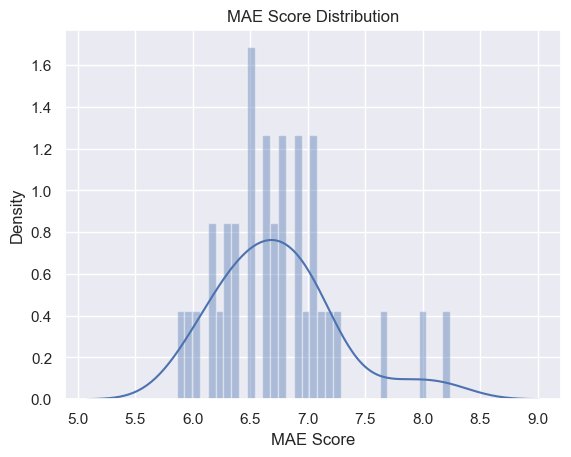

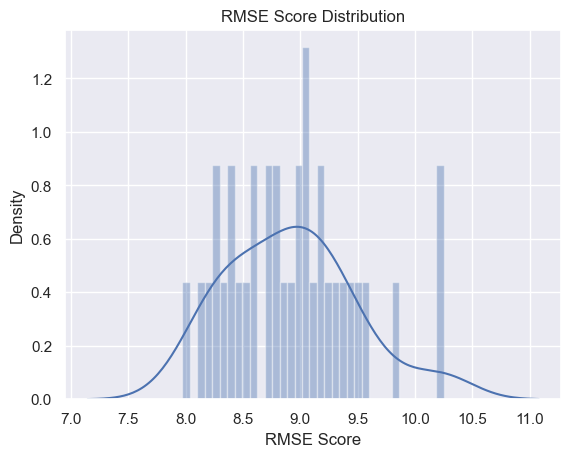

In [14]:
sns.set(style="darkgrid")
sns.distplot(mae_values_2, bins=35).set_title('MAE Score Distribution')
plt.xlabel("MAE Score")
plt.show()

sns.set(style="darkgrid")
sns.distplot(rmse_values_2, bins=35).set_title('RMSE Score Distribution')
plt.xlabel("RMSE Score")
plt.show()

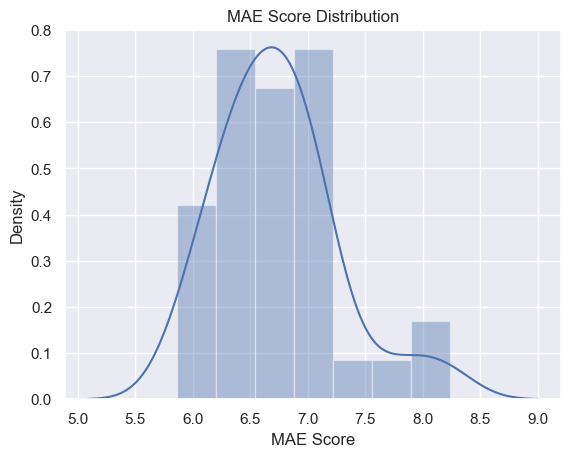

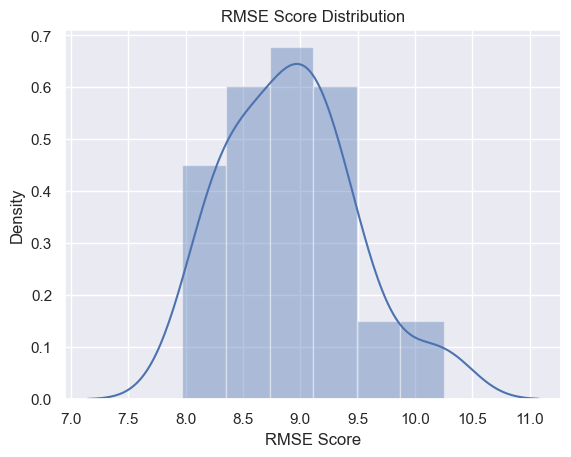

In [15]:
sns.set(style="darkgrid")
sns.distplot(mae_values_2).set_title('MAE Score Distribution')
plt.xlabel("MAE Score")
plt.show()

sns.set(style="darkgrid")
sns.distplot(rmse_values_2).set_title('RMSE Score Distribution')
plt.xlabel("RMSE Score")
plt.show()

# Results

In [13]:
compare_df.sort_values(by=['MAE'])

,Name,MAE,MAPE,MSE,RMSE
0,LSTM 2,6.7339,0.0161,79.8178,8.917


https://machinelearningmastery.com/estimate-number-experiment-repeats-stochastic-machine-learning-algorithms/